<a href="https://colab.research.google.com/github/dln277/portfolio/blob/main/COVID19_and_CO2_Emission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Flow: CSV -> SQL -> Pandas


**Note: Current database is using password, but not perfect in security.**

**Put your group no and password below.**

In [ ]:
group_no = 3  #PUT YOUR GROUP No. HERE. Ex: 99 You can find your group here: https://docs.google.com/spreadsheets/d/1-fmZJmu5DlwTfAgPEYxLXlzYjhrzk04sjqENCJnRZ5k

#### FOLDABLE (PASSWORD BELOW)

In [ ]:
group_password = "gJcjgTabSx1Jzyz4WWD6" #PUT YOUR GROUP PASSWORD THAT INSTRUCTOR SENT HERE. Ex: "AAAABBBBCCCCDDDDEEEE"

#### Authenticate to secure the connection to database;

In [ ]:
# gcloud login and check the DB.
# This login make your authentication:
# 1. You are asked to "Go to the following link in your browser". Click the link and authenticate there.
# 2. Copy the token below "Please copy this code, switch to your application and paste it there:"
# 3. Paste the token to the square on the right of "Enter verification code:", and push enter button.
!gcloud auth login
!gcloud config set project mysql-ub23-2020spring
!gcloud sql instances describe ub23sqlw

### If the authentication is successful, you will see output like:

```
(very long statement here)
state: RUNNABLE
```



In [ ]:
# This secures the connection to SQL server from Colab (VPN between SQL server and Colab).
# This takes 30 secs.
!wget https://dl.google.com/cloudsql/cloud_sql_proxy.linux.amd64 -O cloud_sql_proxy
!chmod +x cloud_sql_proxy
!nohup ./cloud_sql_proxy -instances="mysql-ub23-2020spring:us-east1:ub23sqlw"=tcp:5432 &
!sleep 30s
# Installing related libraries to Colab. 
!sudo apt-get install python3-dev libmysqlclient-dev > /dev/null
!pip install mysqlclient > /dev/null
!sudo pip3 install -U sql_magic > /dev/null
import sqlalchemy
# Render our plots inline
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Importing dataframe libraries
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# Make the graphs a bit bigger
matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])

cloud_sql_proxy: Text file busy
nohup: appending output to 'nohup.out'


#### Now, let us connect to the SQL server

In [ ]:
# Connect to SQL server.
from sqlalchemy import create_engine
db_name = 'dbpriv_group_'+str(group_no)
conn_string = 'mysql://{user}:{password}@{host}/{database}?charset=utf8'.format(
    host = '127.0.0.1:5432', 
    user = "group_" + str(group_no),
    password = group_password,
    database = db_name)

engine = create_engine(conn_string)
con = engine.connect()
print(con)

### IF the connections is established. You will see texts like 

```
<sqlalchemy.engine.base.Connection object at 0x7f8242330780>
```



In [ ]:
# Prepare sql_magic library that enable to query to database easily.
%reload_ext sql_magic
%config SQL.conn_name = 'engine'

In [ ]:
#  This cell limits the maximum number of records to obtain.
%%read_sql
SET sql_safe_updates=1, sql_select_limit=10000, max_join_size=1000000000;

Query started at 06:34:51 PM UTC; Query executed in 0.00 m

## 1. Now we are all set! Let us start making our own database.

#### IMPORTING DATA

In [ ]:
# This prompts you to upload the file to Colab cloud machine.
from google.colab import files
uploaded = files.upload()

Saving covid19.csv to covid19.csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving co2emission.csv to co2emission.csv


In [ ]:
#you can check the file is uploaded on the Colab cloud
!ls

cloud_sql_proxy  co2emission.csv  covid19.csv  nohup.out  sample_data


In [ ]:
# read the data into pandas 
co2_emission = pd.read_csv('co2emission.csv', 
                          encoding='utf_8', 
                          dtype = 'unicode',
                          parse_dates = True,
                          infer_datetime_format = True,
                          low_memory=False)
co2_emission.head(5)

,Country Name,Code,GDP Per Capita (USD),CO2 Emissions Per Capita (kg),Population Density (Per Sq Km),Unnamed: 5,Unnamed: 6
0,Albania,ALB,4578.666728,1978.763312,105.4417518,NaN,NaN
1,Algeria,DZA,5466.425778,3717.409901,16.42215901,NaN,NaN
2,Angola,AGO,4709.312024,1291.328315,21.59337932,NaN,NaN
3,Argentina,ARG,12245.25645,4746.797455,15.7056572,NaN,NaN
4,Armenia,ARM,3994.712355,1902.75891,102.0800843,NaN,NaN


In [ ]:
# read the data into pandas 
covid19 = pd.read_csv('covid19.csv', 
                          encoding='utf_8', 
                          dtype = 'unicode',
                          parse_dates = True,
                          infer_datetime_format = True,
                          low_memory= False)
covid19.head(5)

,Date,Country,Code,Confirmed,Recovered,Deaths
0,4/26/20,Afghanistan,AFG,1531,207,50
1,4/26/20,Albania,ALB,726,410,28
2,4/26/20,Algeria,DZA,3382,1508,425
3,4/26/20,Andorra,AND,738,344,40
4,4/26/20,Angola,AGO,26,6,2


## 2. Data cleaning and preparations before executing queries and analysis

Checking, formating data types, and a few house keeping items before executing queries and analysis


In [ ]:
#I'd  like to rename the first column in CO2 Emission dataset to by "Country" instead of "Country Name" for consistency
co2_emission = co2_emission.rename(columns={"Country Name": "Country"})
#I'd also like to rename the other columns to more query-friendly names
co2_emission = co2_emission.rename(columns={"GDP Per Capita (USD)": "GDP", "CO2 Emissions Per Capita (kg)": "CO2Emission", "Population Density (Per Sq Km)": "PopDen", "Latitude": "Lat", "Longtitude": "Long"})
co2_emission.head(5)

,Country,Code,GDP,CO2Emission,PopDen,Unnamed: 5,Unnamed: 6
0,Albania,ALB,4578.666728,1978.763312,105.4417518,NaN,NaN
1,Algeria,DZA,5466.425778,3717.409901,16.42215901,NaN,NaN
2,Angola,AGO,4709.312024,1291.328315,21.59337932,NaN,NaN
3,Argentina,ARG,12245.25645,4746.797455,15.7056572,NaN,NaN
4,Armenia,ARM,3994.712355,1902.75891,102.0800843,NaN,NaN


In [ ]:
#Remove the last two empty columns
co2_emission=co2_emission.drop(columns=['Unnamed: 5', 'Unnamed: 6'])
#We also are not particularly interested in GDP and Population Density for the purpose of this project. I will drop those columns as well.
co2_emission=co2_emission.drop(columns=['GDP', 'PopDen'])


co2_emission.head(5)

,Country,Code,CO2Emission
0,Albania,ALB,1978.763312
1,Algeria,DZA,3717.409901
2,Angola,AGO,1291.328315
3,Argentina,ARG,4746.797455
4,Armenia,ARM,1902.75891


In [ ]:
#Convert columns to the corret datatype
co2_emission["CO2Emission"] = pd.to_numeric(co2_emission["CO2Emission"])
co2_emission.dtypes

Country         object
Code            object
CO2Emission    float64
dtype: object

In [ ]:
#While it is useful to know that the numbers of COVID19 were reported on 4/26/2020, it is redundant for the purpose of this report. Thus, I will remove the column.
covid19 = covid19.drop(columns=['Date'])
covid19.head(5)

,Country,Code,Confirmed,Recovered,Deaths
0,Afghanistan,AFG,1531,207,50
1,Albania,ALB,726,410,28
2,Algeria,DZA,3382,1508,425
3,Andorra,AND,738,344,40
4,Angola,AGO,26,6,2


In [ ]:
#CO2 Emission measurement is standardize across countries (in unit kg of Per Capita) such that higher population does not result in higher CO2 Emission.
#Therefore, it would be a fair comparison between different countries. 
#However, the COVID19 dataset have not been standardize 
#(i.e. more populated countries, such as the US, has a larger number of confirmed cases vs smaller countries, like Italy, has fewer number of cases. One may assume that the US is doing worse than Italy, though that might not be the case)
#We proceed to standardize the effect of COVID19 on different countries by calculating the percentage of cases out of country total population.
#First, we'll import world population data from World Bank database
from google.colab import files
uploaded = files.upload()

Saving API_SP.POP.TOTL_DS2_en_excel_v2_988396.xls to API_SP.POP.TOTL_DS2_en_excel_v2_988396.xls


In [ ]:
#Read the data into pandas
pop = pd.read_excel('API_SP.POP.TOTL_DS2_en_excel_v2_988396.xls')

pop.head()

,Country Name,Country Code,2014,2015,2016,2017,2018
0,Aruba,ABW,103774.0,104341.0,104872.0,105366.0,105845.0
1,Afghanistan,AFG,33370794.0,34413603.0,35383128.0,36296400.0,37172386.0
2,Angola,AGO,26941779.0,27884381.0,28842484.0,29816748.0,30809762.0
3,Albania,ALB,2889104.0,2880703.0,2876101.0,2873457.0,2866376.0
4,Andorra,AND,79213.0,78011.0,77297.0,77001.0,77006.0


In [ ]:
#Merge the COVID19 dataset with populations dataset on country code (country names may be inconsistent throughout different databases but country code is standardized)
covid19 = covid19.merge(pop, left_on= 'Code', right_on='Country Code')
covid19.head()

,Country,Code,Confirmed,Recovered,Deaths,Country Name,Country Code,2014,2015,2016,2017,2018
0,Afghanistan,AFG,1531,207,50,Afghanistan,AFG,33370794.0,34413603.0,35383128.0,36296400.0,37172386.0
1,Albania,ALB,726,410,28,Albania,ALB,2889104.0,2880703.0,2876101.0,2873457.0,2866376.0
2,Algeria,DZA,3382,1508,425,Algeria,DZA,38923687.0,39728025.0,40551404.0,41389198.0,42228429.0
3,Andorra,AND,738,344,40,Andorra,AND,79213.0,78011.0,77297.0,77001.0,77006.0
4,Angola,AGO,26,6,2,Angola,AGO,26941779.0,27884381.0,28842484.0,29816748.0,30809762.0


In [ ]:
#Unfortunately, the database only provides the number of world population up till the year 2018
#For the purpose of the project, we will use the population data from 2018, assuming that it is not significantly different from 2020 world population
#Now we can cleanup the dataframe by dropping repeated columns and populations from earlier years
covid19 = covid19.drop(columns=['Country Name', 'Country Code', '2014','2015','2016','2017'])
covid19.head()

,Country,Code,Confirmed,Recovered,Deaths,2018
0,Afghanistan,AFG,1531,207,50,37172386.0
1,Albania,ALB,726,410,28,2866376.0
2,Algeria,DZA,3382,1508,425,42228429.0
3,Andorra,AND,738,344,40,77006.0
4,Angola,AGO,26,6,2,30809762.0


In [ ]:
#Similarly, some bookkeeping regarding datatypes for the COVID19 dataset
covid19['Confirmed'] = pd.to_numeric(covid19['Confirmed'])
covid19['Recovered'] = pd.to_numeric(covid19['Recovered'])
covid19['Deaths'] = pd.to_numeric(covid19['Deaths'])
covid19['2018'] = pd.to_numeric(covid19['2018'])
covid19.dtypes

Country       object
Code          object
Confirmed      int64
Recovered      int64
Deaths         int64
2018         float64
dtype: object

In [ ]:
#We now calculate the number of confirmed, deaths, and recovered cases as a percentage of the country's population

confirmed_per = covid19['Confirmed']/ covid19['2018']*100
recovered_per = covid19['Recovered']/ covid19['2018']*100
deaths_per = covid19['Deaths']/ covid19['2018']*100
covid19['confirmed_per']= confirmed_per.values
covid19['recovered_per']= recovered_per.values
covid19['deaths_per']= deaths_per.values


covid19.head()

,Country,Code,Confirmed,Recovered,Deaths,2018,confirmed_per,recovered_per,deaths_per
0,Afghanistan,AFG,1531,207,50,37172386.0,0.004119,0.000557,0.000135
1,Albania,ALB,726,410,28,2866376.0,0.025328,0.014304,0.000977
2,Algeria,DZA,3382,1508,425,42228429.0,0.008009,0.003571,0.001006
3,Andorra,AND,738,344,40,77006.0,0.958367,0.446718,0.051944
4,Angola,AGO,26,6,2,30809762.0,0.000084,0.000019,0.000006


In [ ]:
#Checking the datatypes of the updated COVID19 dataframe
covid19.dtypes

Country           object
Code              object
Confirmed          int64
Recovered          int64
Deaths             int64
2018             float64
confirmed_per    float64
recovered_per    float64
deaths_per       float64
dtype: object

##3. Convert Dataframes into SQL Tables

In [ ]:
#Convert CO2 dataframe into SQL table
db_name = 'dbpriv_group_'+str(group_no)
co2_emission.to_sql(name = "co2_emission", 
          schema = db_name, 
          con = engine, 
          if_exists = 'replace', 
          index = False,
          chunksize = 1000)

In [ ]:
%%read_sql 
SELECT * FROM co2_emission;

Query started at 06:35:40 PM UTC; Query executed in 0.00 m

,Country,Code,CO2Emission
0,Albania,ALB,1978.763312
1,Algeria,DZA,3717.409901
2,Angola,AGO,1291.328315
3,Argentina,ARG,4746.797455
4,Armenia,ARM,1902.758910
...,...,...,...
120,Turkmenistan,TKM,12517.295340
121,Ukraine,UKR,5020.747064
122,United Kingdom,GBR,6497.440490
123,United States,USA,46493.666130


In [ ]:
#Convert covid19 dataframe into SQL table
db_name = 'dbpriv_group_'+str(group_no)
covid19.to_sql(name = "covid19", 
          schema = db_name, 
          con = engine, 
          if_exists = 'replace', 
          index = False,
          chunksize = 1000)

In [ ]:
%%read_sql
SELECT * FROM covid19 ;

Query started at 06:35:45 PM UTC; Query executed in 0.00 m

,Country,Code,Confirmed,Recovered,Deaths,2018,confirmed_per,recovered_per,deaths_per
0,Afghanistan,AFG,1531,207,50,37172386.0,0.004119,0.000557,0.000135
1,Albania,ALB,726,410,28,2866376.0,0.025328,0.014304,0.000977
2,Algeria,DZA,3382,1508,425,42228429.0,0.008009,0.003571,0.001006
3,Andorra,AND,738,344,40,77006.0,0.958367,0.446718,0.051944
4,Angola,AGO,26,6,2,30809762.0,0.000084,0.000019,0.000006
...,...,...,...,...,...,...,...,...,...
169,Venezuela,VEN,325,137,10,28870195.0,0.001126,0.000475,0.000035
170,Vietnam,VNM,270,225,0,95540395.0,0.000283,0.000236,0.000000
171,Yemen,YEM,1,1,0,28498687.0,0.000004,0.000004,0.000000
172,Zambia,ZMB,88,42,3,17351822.0,0.000507,0.000242,0.000017


In [ ]:
#Before proceeding, let's double check the schema of the structures
%%read_sql
DESCRIBE co2_emission;

Query started at 06:35:48 PM UTC; Query executed in 0.00 m

,Field,Type,Null,Key,Default,Extra
0,Country,text,YES,,None,
1,Code,text,YES,,None,
2,CO2Emission,double,YES,,None,


In [ ]:
%%read_sql
DESCRIBE covid19;

Query started at 06:35:50 PM UTC; Query executed in 0.00 m

,Field,Type,Null,Key,Default,Extra
0,Country,text,YES,,None,
1,Code,text,YES,,None,
2,Confirmed,bigint(20),YES,,None,
3,Recovered,bigint(20),YES,,None,
4,Deaths,bigint(20),YES,,None,
5,2018,double,YES,,None,
6,confirmed_per,double,YES,,None,
7,recovered_per,double,YES,,None,
8,deaths_per,double,YES,,None,


##4. Querying Dataset

In [ ]:
#Let's find the top 10 countries that has the highest CO2 Emission per capita in the order of highest emission rate to the lowest
%%read_sql
SELECT Country, CO2Emission 
FROM co2_emission
ORDER BY CO2Emission DESC
LIMIT 10;

Query started at 06:35:53 PM UTC; Query executed in 0.00 m

,Country,CO2Emission
0,China,57433.90764
1,United States,46493.66613
2,Qatar,45423.23996
3,Trinidad and Tobago,34163.24263
4,India,31730.00043
5,Kuwait,25223.86443
6,Bahrain,23449.75483
7,Brunei,22124.70124
8,Saudi Arabia,19529.27180
9,Luxembourg,17362.12137


In [ ]:
#We would also like to examine the top 10 countries that are most affected by the virus by percentage of confirmed cases
%%read_sql
SELECT Country, confirmed_per, recovered_per, deaths_per 
FROM covid19
ORDER BY confirmed_per DESC
LIMIT 10;

Query started at 06:35:56 PM UTC; Query executed in 0.00 m

,Country,confirmed_per,recovered_per,deaths_per
0,San Marino,1.592423,0.189433,0.121356
1,Andorra,0.958367,0.446718,0.051944
2,Luxembourg,0.612386,0.510568,0.014475
3,Iceland,0.508050,0.455884,0.002835
4,Spain,0.484286,0.251572,0.049555
5,Belgium,0.403507,0.094330,0.062047
6,Ireland,0.395742,0.189694,0.022333
7,Qatar,0.369813,0.036381,0.000359
8,Switzerland,0.341363,0.256072,0.018912
9,Italy,0.327159,0.107458,0.044097


In [ ]:
#Interestingly, countries with large populations that are heavily affected by the virus, namely China and US, do not appear on the list
#We see some overlaps in these two tables -- some countries that have high CO2 emission rate that also has high percentage of confirmed cases are: Qatar and Luxemburg -- quite interesting

In [ ]:
#Since COVID19 spread is time-sensitive (i.e. some countries were affected early and now the spread has plateaued, while some others just reached their peaks)
#Thereofore, I'll also take a look at the percentage of deaths to measure COVID19's impact
%%read_sql
SELECT Country, confirmed_per, recovered_per, deaths_per 
FROM covid19
ORDER BY deaths_per DESC
LIMIT 10;

Query started at 06:36:01 PM UTC; Query executed in 0.00 m

,Country,confirmed_per,recovered_per,deaths_per
0,San Marino,1.592423,0.189433,0.121356
1,Belgium,0.403507,0.094330,0.062047
2,Andorra,0.958367,0.446718,0.051944
3,Spain,0.484286,0.251572,0.049555
4,Italy,0.327159,0.107458,0.044097
5,France,0.242202,0.068204,0.034176
6,United Kingdom,0.231773,0.001171,0.031288
7,Netherlands,0.220757,0.000679,0.026063
8,Ireland,0.395742,0.189694,0.022333
9,Sweden,0.183190,0.009877,0.021562


In [ ]:
#Interestingly, there is no overlap between the percentage of deaths and CO2 Emission rate. 
#This could be explained by the smaller percentage of deaths compared to percentage of confirmed cases world wide, thus, it is more difficult to see the relationship.
#However, we see some countries that appear in both of the last two tables, confirming that they are the most impacted by COVID19.

In [ ]:
#In the above queries, we see a few interesting overlaps between the tables. 
#Let's examine this further by comparing them to the world averages.
%%read_sql
SELECT AVG(CO2Emission), AVG(confirmed_per), AVG(deaths_per) 
FROM covid19 v 
INNER JOIN co2_emission e ON v.Code=e.Code;

Query started at 06:36:06 PM UTC; Query executed in 0.00 m

,AVG(CO2Emission),AVG(confirmed_per),AVG(deaths_per)
0,6700.468692,0.075116,0.003895


In [ ]:
#Let's take a look to see which countries are heavily affected by the virus while also having a significant carbon footprint relative to the world averages.
%%read_sql
SELECT * FROM covid19  
INNER JOIN co2_emission USING(Code)
WHERE confirmed_per >= 0.075116
AND deaths_per >= 0.003895
AND CO2Emission >= 6700.468692	
ORDER BY confirmed_per DESC
;

Query started at 06:36:11 PM UTC; Query executed in 0.00 m

,Code,Country,Confirmed,Recovered,Deaths,2018,confirmed_per,recovered_per,deaths_per,Country,CO2Emission
0,LUX,Luxembourg,3723,3104,88,607950.0,0.612386,0.510568,0.014475,Luxembourg,17362.121370
1,BEL,Belgium,46134,10785,7094,11433256.0,0.403507,0.094330,0.062047,Belgium,8328.159898
2,IRL,Ireland,19262,9233,1087,4867309.0,0.395742,0.189694,0.022333,Ireland,7378.117809
3,USA,United States,965785,106988,54881,326687501.0,0.295630,0.032749,0.016799,United States,46493.666130
4,NLD,Netherlands,38040,117,4491,17231624.0,0.220757,0.000679,0.026063,Netherlands,9920.138075
5,DEU,Germany,157770,112000,5976,82905782.0,0.190300,0.135093,0.007208,Germany,8889.370395
6,AUT,Austria,15225,12282,542,8840521.0,0.172218,0.138928,0.006131,Austria,6873.713220
7,CAN,Canada,47145,16883,2661,37057765.0,0.127220,0.045559,0.007181,Canada,15117.158780
8,IRN,Iran,90481,69657,5710,81800269.0,0.110612,0.085155,0.006980,Iran,8283.020787


Despite a few overlaps in the tables, it is still difficult to see whether there is a relationship between high CO2 Emissions and detrimental effects from COVID19. We further examine the relationship with the following plots. 

## 5. Data Visualization and Statistical Analysis

In [ ]:
#I would first like to visualize datasets geographically using choropleth maps. 
#First, I install all the necessary packages for choropleth mapping. 
!pip install geopandas 

import os
import geopandas as gpd


#Read shapefile using Geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))[['iso_a3','geometry']]
#Examine the country GeoDataFrame 
world.head()

,iso_a3,geometry
0,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,ESH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [ ]:
#Merge COVID19 dataset with the world geometry dataset for geographing.  
merged_covid = world.merge(covid19, left_on= 'iso_a3', right_on='Code')
merged_covid.head()

,iso_a3,geometry,Country,Code,Confirmed,Recovered,Deaths,2018,confirmed_per,recovered_per,deaths_per
0,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",Fiji,FJI,18,12,0,883483.0,0.002037,0.001358,0.000000
1,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",Tanzania,TZA,299,48,10,56318348.0,0.000531,0.000085,0.000018
2,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",Canada,CAN,47145,16883,2661,37057765.0,0.127220,0.045559,0.007181
3,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",United States,USA,965785,106988,54881,326687501.0,0.295630,0.032749,0.016799
4,KAZ,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",Kazakhstan,KAZ,2717,682,25,18272430.0,0.014869,0.003732,0.000137


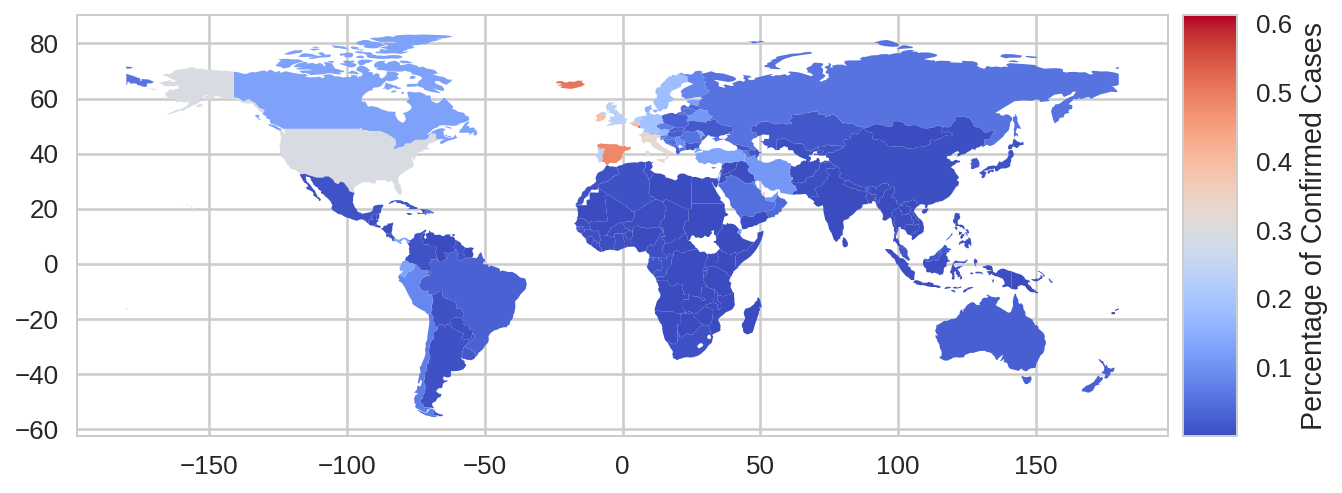

In [ ]:
#We now plot the choropleth map of COVID19's effect on world countries
#We'll first look at countries based on their percentage of confirmed cases
#Source code: https://geopandas.org/mapping.html
from mpl_toolkits.axes_grid1 import make_axes_locatable

#To set up the choropleth map:
fig, ax = plt.subplots(1,1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

#Setting the plotted variable, map color scheme, and legend label: 
merged_covid.plot(column='confirmed_per', cmap='coolwarm', ax=ax ,legend = True,legend_kwds={'label': "Percentage of Confirmed Cases"}, cax=cax)


In [ ]:
#The map confirms what we had seen in the querying result. The countries most affected based on percentage of confimed cases, noted in red and gray, are Iceland, Spain, Italy, Ireland, and the US. 

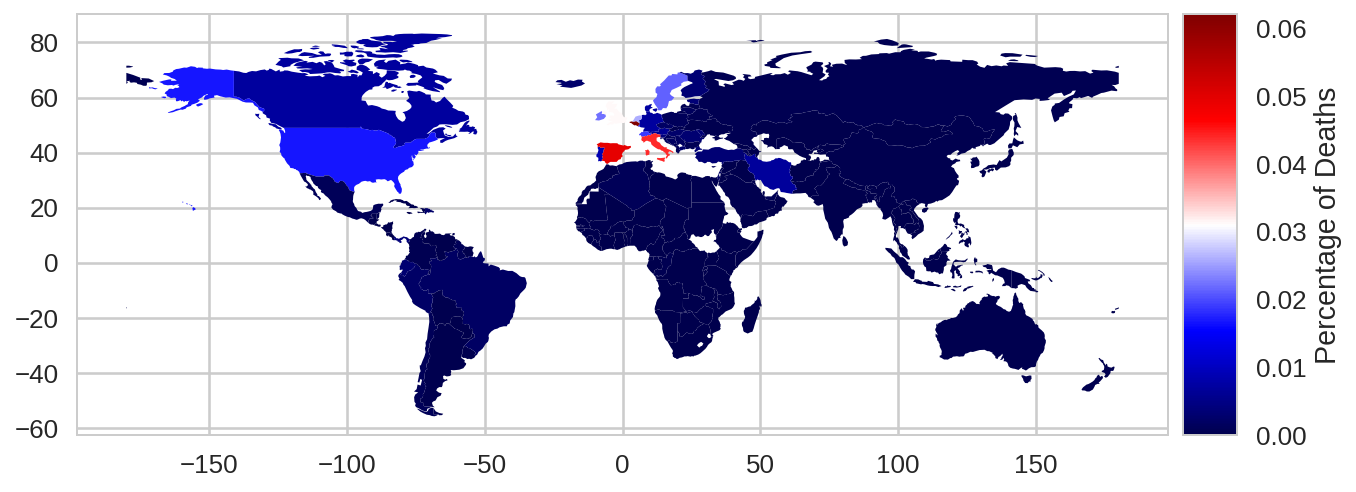

In [ ]:
#Now we'll take a look at the percentage of deaths 

#To set up the choropleth map:
fig, ax = plt.subplots(1,1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

#Setting the plotted variable, map color scheme, and legend label: 
merged_covid.plot(column='deaths_per', cmap='seismic', ax=ax ,legend = True, legend_kwds={'label': "Percentage of Deaths"}, cax=cax)

In [ ]:
#Similarly, the map tells us that the most affected countries in percentage of deaths, signified by red and light blue, are: Spain, Italy, Belgium, France, UK, and Sweden. 

In [ ]:
#Now we'll take a look at the world's CO2 Emission by merging the dataset with world geographies dataset. 
merged_co2 = world.merge(co2_emission, left_on= 'iso_a3', right_on='Code')

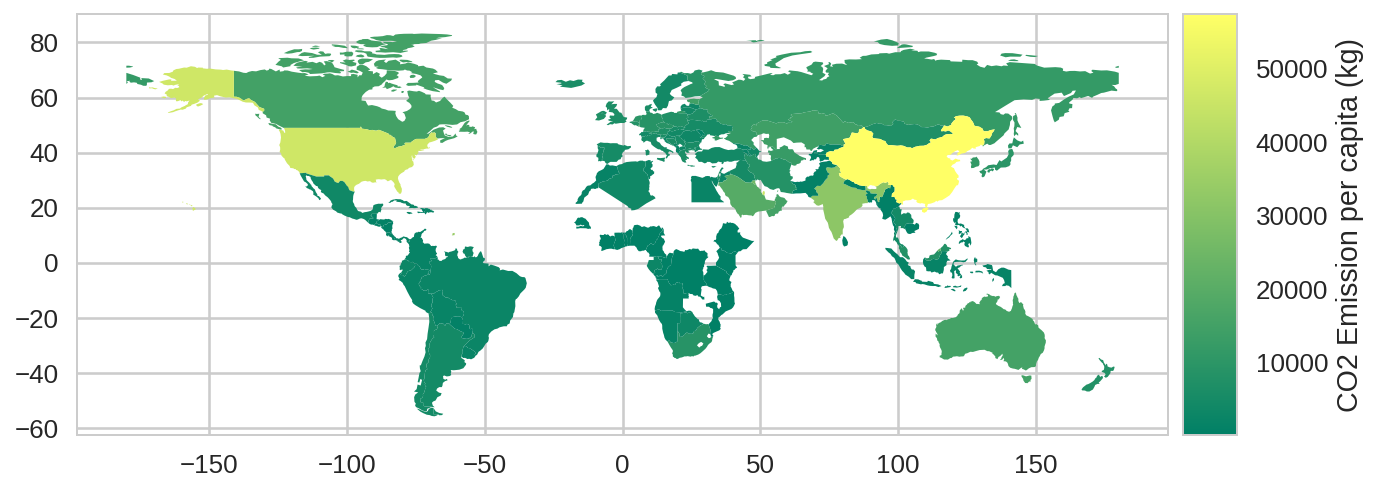

In [ ]:
#To set up the choropleth map:
fig, ax = plt.subplots(1,1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

#Setting the plotted variable, map color scheme, and legend label: 
merged_co2.plot(column='CO2Emission', cmap='summer', ax=ax ,legend = True, legend_kwds={'label': "CO2 Emission per capita (kg)"}, cax=cax)

In [ ]:
#The choropleth map of CO2 Emission rate confirmes the querying result of contries with highest carbon footprint, seen in yellow and light green, are: China, US, and India.

In [ ]:
#Lastly, we will examine the relationship between CO2 emission and COVID19 impact with linear regression.
#We will first merge the two datasets, remove redundant columns, and rename columns. 
covid_co2 = covid19.merge(co2_emission, left_on= 'Code', right_on='Code')
covid_co2 = covid_co2.drop(columns=['Country_y'])
covid_co2 = covid_co2.rename(columns={"Country_x": "Country"})

#We now remove null values in order to proceed with linear regression analysis. 
covid_co2 = covid_co2.dropna() 

covid_co2.head()

,Country,Code,Confirmed,Recovered,Deaths,2018,confirmed_per,recovered_per,deaths_per,CO2Emission
0,Albania,ALB,726,410,28,2866376.0,0.025328,0.014304,0.000977,1978.763312
1,Algeria,DZA,3382,1508,425,42228429.0,0.008009,0.003571,0.001006,3717.409901
2,Angola,AGO,26,6,2,30809762.0,0.000084,0.000019,0.000006,1291.328315
3,Argentina,ARG,3892,1107,192,44494502.0,0.008747,0.002488,0.000432,4746.797455
4,Armenia,ARM,1746,833,28,2951776.0,0.059151,0.028220,0.000949,1902.758910


In [ ]:
#We will now run a linear regression 
#Source code: https://stackoverflow.com/questions/19991445/run-an-ols-regression-with-pandas-data-frame
import statsmodels.api as sm

# Change the series dimensions to 1 dimensional series
x = covid_co2['CO2Emission']
y = covid_co2['confirmed_per']

#Build the model and assign variables
model = sm.OLS(y, x).fit() 
predictions = model.predict(x) # make the predictions by the model

#Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          confirmed_per   R-squared (uncentered):                   0.254
Model:                            OLS   Adj. R-squared (uncentered):              0.248
Method:                 Least Squares   F-statistic:                              40.80
Date:                Sun, 10 May 2020   Prob (F-statistic):                    3.33e-09
Time:                        18:38:46   Log-Likelihood:                          84.782
No. Observations:                 121   AIC:                                     -167.6
Df Residuals:                     120   BIC:                                     -164.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
CO2Emission  6.144e-06   9.62e-07      6.388      0.000    4.24e-06    8.05e-06
==============================================================================
Omnibus:                       55.339   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.830
Skew:                           1.616   Prob(JB):                     9.04e-45
Kurtosis:                       8.458   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#With the CO2 Emission rate per capita as the predictor and COVID19 confirmed percentage as the target variable, the model outputs a positive coefficient with a p value of 0, meaning that there is strong evidence against the null hypothesis. 
#The positive coefficient suggests that there is a positive relationship between a country’s CO2 Emission rate and its percentage of confirmed COVID19 cases. 
#The correlation can be better visualized with a scatterplot. 

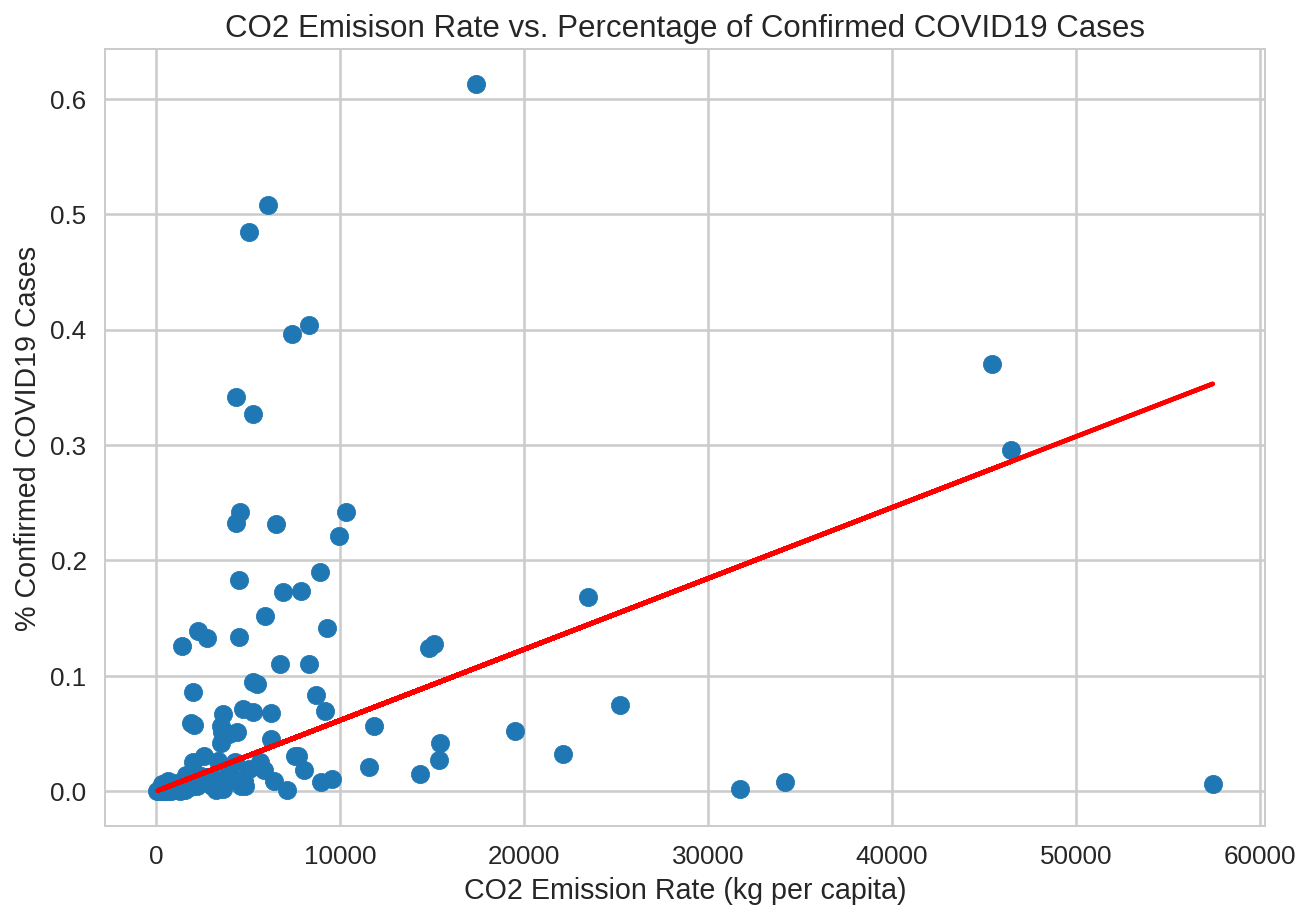

In [ ]:
plt.scatter(x,y) #choose the plot type 
plt.plot(x,predictions, color ='red') #assign axis and color 
plt.title('CO2 Emisison Rate vs. Percentage of Confirmed COVID19 Cases')  #assign title and axis labels
plt.xlabel('CO2 Emission Rate (kg per capita)')  
plt.ylabel('% Confirmed COVID19 Cases')
plt.show() #plot the graph

In [ ]:
#I want the graph to be more interactive in order to examine which countries are outliers. 
#Source code: https://plotly.com/python/line-and-scatter/

import plotly.graph_objects as go #import interactive marker for scatterplot

fig=go.Figure()

fig.add_trace(go.Scatter(x=x, y=y,
                    mode='markers',
                    name = 'data',
                    text=covid_co2['Country'])) #graph scatterplot of the datasets and display the corresponding country when hover over
fig.add_trace(go.Scatter(x=x, 
                         y=predictions,
                         name = 'linear regression',
                         mode='lines')) #graph the linear regression line

fig.show()


In [ ]:
#According to the scatterplot, there is a linear positive correlation between a country's CO2 Emission Rate and its percentage of confirmed COVID19 cases. 
#From the scatterplot, we can see that the dataset is clustered in the bottom left corner. 
#This is not surprising as these are representative of developing countries (with a few exceptions), which have low CO2 emission rate while developed countries have higher carbon footprint. 
#The two notable outliers are China (bottom right) and Luxembourg (top middle). 
#Although China has a relatively small percentage of confirmed cases, it is the number 1 country in terms of carbon emission.
#Luxembourg is an interesting outlier since it has very high percentage of confirmed cases (and it appeared in all of our querying results).
#I will not remove these outliers since the dataset is already relatively small (only 121 observations).

In [ ]:
#I'm also curious in examinine the correlation between CO2 Emission and percentage of deaths due to COVID19

# Change the series dimensions to 1 dimensional series
x2 = covid_co2['CO2Emission']
y2 = covid_co2['deaths_per']

#Build the model and assign variables:
model2 = sm.OLS(y2, x2).fit() 
predictions2 = model.predict(x2) # make the predictions by the model

#Print out the statistics
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             deaths_per   R-squared (uncentered):                   0.071
Model:                            OLS   Adj. R-squared (uncentered):              0.064
Method:                 Least Squares   F-statistic:                              9.209
Date:                Sun, 10 May 2020   Prob (F-statistic):                     0.00295
Time:                        18:55:55   Log-Likelihood:                          383.81
No. Observations:                 121   AIC:                                     -765.6
Df Residuals:                     120   BIC:                                     -762.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
CO2Emission  2.466e-07   8.13e-08      3.035      0.003    8.57e-08    4.07e-07
==============================================================================
Omnibus:                      119.992   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1340.494
Skew:                           3.595   Prob(JB):                    8.23e-292
Kurtosis:                      17.635   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#With the CO2 Emission rate per capita as the predictor and COVID19 deaths percentage as the target variable, the model outputs a positive coefficient with a p value of 0, meaning that there is strong evidence against the null hypothesis. 
#The positive coefficient suggests that there is a positive relationship between a country’s CO2 Emission rate and its percentage of COVID19 deaths. 
#In fact, there is a higher positive correlation between CO2 Emission and deaths_per than CO2 Emission and confirmed_per.
#This makes sense since high CO2 emisison is highly correlated with increased respiratory diseases and those with such diseases are more likely to be severely ill if infected by COVID19. 
#The correlation can be better visualized with a scatterplot.

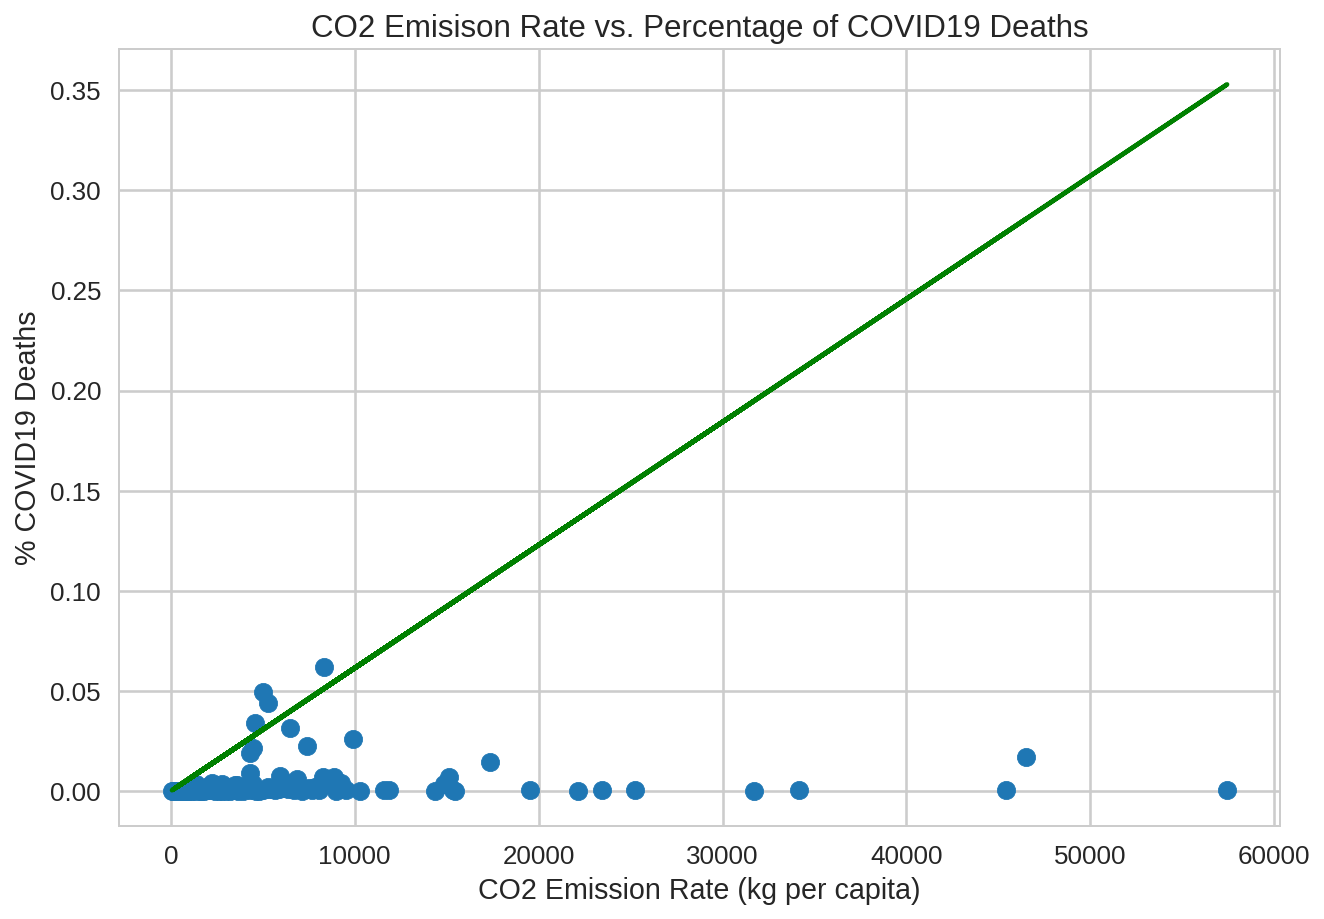

In [ ]:
plt.scatter(x2,y2) #choose the type of graph
plt.plot(x2,predictions, color ='green') #assign axis and color
plt.title('CO2 Emisison Rate vs. Percentage of COVID19 Deaths') #assign title and axis labels
plt.xlabel('CO2 Emission Rate (kg per capita)')  
plt.ylabel('% COVID19 Deaths')
plt.show()

In [ ]:
#Similarly, I would like to plot an interactive map to understand outliers
fig2=go.Figure()

fig2.add_trace(go.Scatter(x=x2, y=y2,
                    mode='markers',
                    name = 'data',
                    text=covid_co2['Country'])) #graph scatterplot of the datasets and display the corresponding country when hover over
fig2.add_trace(go.Scatter(x=x2, 
                         y=predictions2,
                         name = 'linear regression',
                         mode='lines')) #graph the linear regression line

fig2.show()

In [ ]:
#The scatterplot shows a highly positive correlation between a country's CO2 Emission Rate and its percentage of COVID19 deaths. 
#Compared to the previous scatterplot, there are no outliers with regards to COVID19 impact as all countries' deaths percentage are less than 0.06%.
#There are clear outliers, such as China, United States, Qatar, and Trinidad and Tobago due to their high CO2 Emission Rate. 

In conclusion, the models prove that there is a positive correlation between a country’s CO2 emission rate and its percentage of confirmed COVID19 cases as well as a positive correlation between their CO2 emission rate and percentage of COVID19 deaths. 
